# Importing libraries

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE


# Loading .csv

In [39]:
who = pd.read_csv('who.csv')

In [40]:
who.columns

Index(['Unnamed: 0', 'country', 'status', 'life expectancy', 'infant deaths',
       'alcohol', 'percentage expenditure', 'hepatitis b', 'measles', 'bmi',
       'polio', 'total expenditure', 'hiv/aids', 'thinness 1-19 years',
       'income composition of resources', 'schooling'],
      dtype='object')

In [41]:
who.drop(['Unnamed: 0'], axis=1, inplace=True)

In [42]:
who['status'].value_counts()

1.0    160
0.0     32
Name: status, dtype: int64

In [43]:
X = who.drop(['status'], axis = 1)

In [44]:
y = who['status']

# Hot Encoding

In [45]:
numericalX = X.select_dtypes(np.number)
categoricalX = X.select_dtypes(np.object)

In [46]:
encoder = OneHotEncoder(drop='first').fit(categoricalX)
encoded_categorical = encoder.transform(categoricalX).toarray()
encoded_categorical = pd.DataFrame(encoded_categorical)
X = pd.concat([numericalX, encoded_categorical], axis = 1)

# X y Split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [48]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# Fitting the model

In [49]:
clf = RandomForestClassifier(max_depth=6,min_samples_leaf=20,max_features=None,n_estimators=100,
                             bootstrap=True,oob_score=True, random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9305555555555556
0.8541666666666666


# Cross validation

In [50]:
clf = RandomForestClassifier(max_depth=6,min_samples_leaf=20,max_features=None,n_estimators=100,
                             bootstrap=True,oob_score=True, random_state=0)
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=5)
cross_val_scores

array([0.96551724, 0.89655172, 0.96551724, 0.89655172, 0.78571429])

In [51]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (cross_val_scores.mean(), cross_val_scores.std()))

0.90 accuracy with a standard deviation of 0.07


# Upsampling using smote

In [52]:
smote = SMOTE()


In [53]:
X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()

1.0    160
0.0    160
Name: status, dtype: int64

# Y y Split Smote

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.25, random_state=0)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# Fitting the model Smote

In [55]:
clf = RandomForestClassifier(max_depth=3, random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9708333333333333
0.9625


# Cross validation Smote

In [56]:
clf = RandomForestClassifier(max_depth=3, random_state=0)
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=5)
cross_val_scores

array([0.9375    , 0.95833333, 0.9375    , 0.97916667, 1.        ])

In [57]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (cross_val_scores.mean(), cross_val_scores.std()))

0.96 accuracy with a standard deviation of 0.02


# Feature Importance

In [58]:
clf.fit( X_train, y_train)

RandomForestClassifier(max_depth=3, random_state=0)

In [59]:
feature_names = X_train.columns
feature_names = list(feature_names)

In [60]:
df = pd.DataFrame(list(zip(feature_names, clf.feature_importances_)))
df.columns = ['columns_name', 'score_feature_importance']
df.sort_values(by=['score_feature_importance'], ascending = False)

,columns_name,score_feature_importance
0,life expectancy,0.133991
10,thinness 1-19 years,0.102034
11,income composition of resources,0.092834
2,alcohol,0.086359
8,total expenditure,0.080887
...,...,...
40,27,0.000000
100,87,0.000000
42,29,0.000000
97,84,0.000000


In [61]:
#plt.bar(x=df['columns_name'], height=df['score_feature_importance'], color='#087E8B')
#plt.title('Feature Importances Random Forest Classification', size=15)
#plt.xticks(rotation='vertical')
#plt.show()

# Hyper Parameter Tuning: Grid Search (Feat. Import., Smote)

In [62]:
X2 = who[['life expectancy', 'income composition of resources', 'alcohol', 'schooling']].copy()

In [63]:
y2 = who['status']

In [64]:
X2_sm, y2_sm = smote.fit_resample(X2, y2)
y2_sm.value_counts()

1.0    160
0.0    160
Name: status, dtype: int64

In [65]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_sm, y2_sm, test_size=0.20, random_state=0)

In [66]:
X2_train = pd.DataFrame(X2_train)
X2_test = pd.DataFrame(X2_test)

In [67]:
param_grid = {
    'n_estimators': [50, 100,500],
    'min_samples_split': [2, 4],
    'min_samples_leaf' : [1, 2],
    'max_features': ['sqrt']
    ##'max_samples' : ['None', 0.5],
    ##'max_depth':[3,5,10],
    ## 'bootstrap':[True,False] 
    }
clf = RandomForestClassifier(random_state=100)

In [68]:
grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1,)

In [69]:
grid_search.fit(X2_train,y2_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
             n_jobs=-1,
             param_grid={'max_features': ['sqrt'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [50, 100, 500]},
             return_train_score=True)

In [70]:
grid_search.best_params_

{'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

In [71]:
# With Random Forest (incl. smote, grid) only using features 
# 'life expectancy', 'income composition of resources', 'alcohol', 'schooling'
# one can predict whether a country is 
# developing or not with 96% certainty 

clf = RandomForestClassifier(random_state=0, max_features='sqrt', 
                             min_samples_leaf=1, min_samples_split=2, n_estimators=500)
cross_val_scores2 = cross_val_score(clf, X2_train, y2_train, cv=10)
print(np.mean(cross_val_scores2))

0.9533846153846154


In [112]:
cv1 = []

In [113]:
cv2 = []

In [114]:
cv1.append('explained')


In [115]:
cv1.append('not explained')

In [116]:
cv2.append(0.95)

In [117]:
cv2.append(0.05)

In [118]:
cv1


['explained', 'not explained']

In [119]:
cv2

[0.95, 0.05]

In [120]:
cv_dic = {'explanation': cv1, 'percentage': cv2}

In [121]:
cv_df = pd.DataFrame(cv_dic)

In [122]:
cv_df

,explanation,percentage
0,explained,0.95
1,not explained,0.05


<AxesSubplot:title={'center':"Prediction of developmental status by 'life expectancy', 'income composition of resources', 'alcohol', 'schooling'"}, xlabel='explanation', ylabel='percentage'>

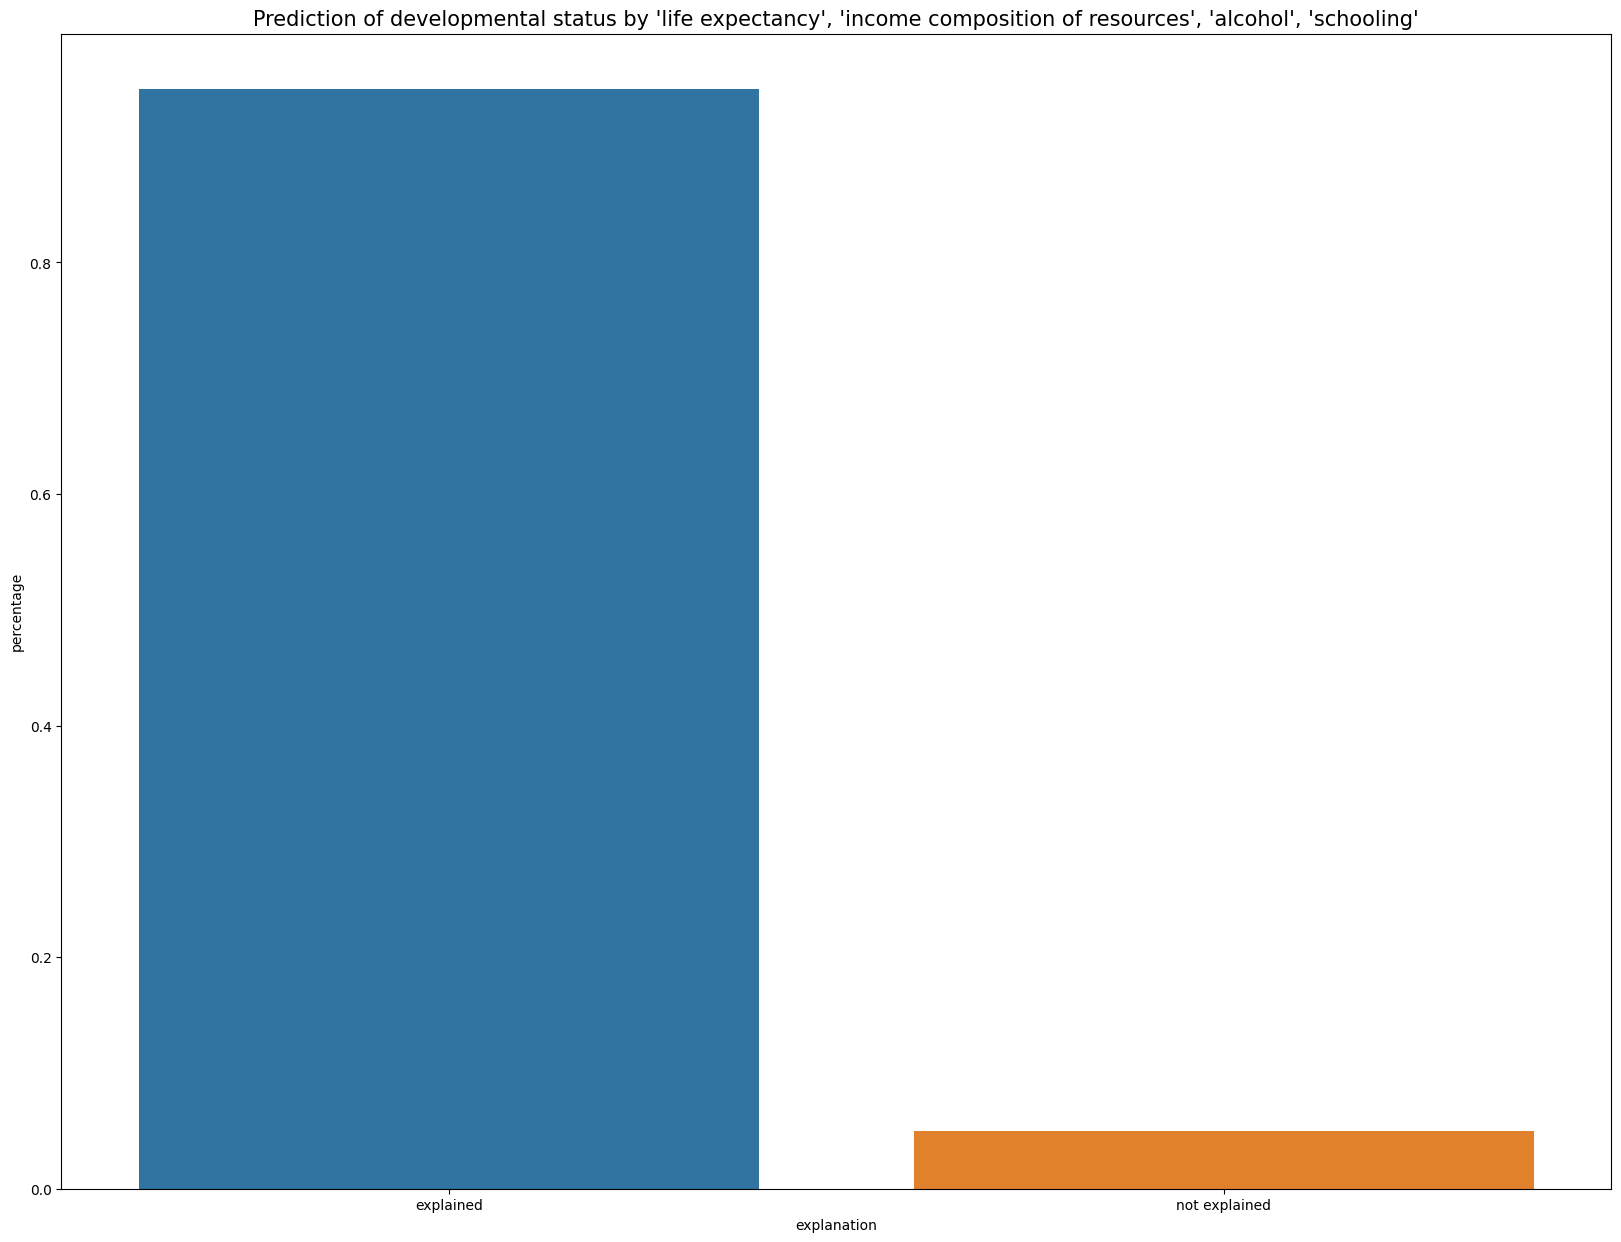

In [123]:
plt.figure(figsize=(20,15))
plt.title("Prediction of developmental status by 'life expectancy', 'income composition of resources', 'alcohol', 'schooling'", size='15',)

sns.barplot(x = cv_df['explanation'],y = cv_df['percentage'])

# Feature importance (FI)


### FI (numerical)

In [74]:
clf.fit(X2_train,y2_train)

RandomForestClassifier(n_estimators=500, random_state=0)

In [76]:
feature_names = X_train.columns
feature_names = list(feature_names)

In [77]:
df = pd.DataFrame(list(zip(feature_names, clf.feature_importances_)))
df.columns = ['columns_name', 'score_feature_importance']
df.sort_values(by=['score_feature_importance'], ascending = False)

,columns_name,score_feature_importance
2,alcohol,0.412199
1,infant deaths,0.333016
0,life expectancy,0.143344
3,percentage expenditure,0.111441
